In [1]:
import json
import smv.DataDict as DataDict
import smv.Vars as Vars
path_tar = "../trace/kbuild-sched-example.tar"
path_json = "../line/freq4_new.json"

In [2]:
var = Vars.Vars(Vars.from_tar(path_tar))
dd = DataDict.from_tar(path_tar,var)
json_config = var.parse(json.load(open(path_json)))

kbuild-sched-example/sched_log/tracer_npz/comm.npz loaded in 0.18357276916503906 s
kbuild-sched-example/sched_log/tracer_npz/event.npz loaded in 0.20183777809143066 s
kbuild-sched-example/sched_log/tracer_npz/arg0.npz loaded in 0.1980898380279541 s
kbuild-sched-example/sched_log/tracer_npz/cpu.npz loaded in 0.2325425148010254 s
kbuild-sched-example/sched_log/tracer_npz/addr.npz loaded in 0.22267866134643555 s
kbuild-sched-example/sched_log/tracer_npz/timestamp.npz loaded in 0.25725269317626953 s
kbuild-sched-example/sched_log/tracer_npz/arg1.npz loaded in 0.229109525680542 s
kbuild-sched-example/sched_log/tracer_npz/pid.npz loaded in 0.2310495376586914 s
kbuild-sched-example/sched_log/tracer_npz/prv_frq_on_same_cpu.npz loaded in 0.23608040809631348 s
kbuild-sched-example/sched_log/tracer_npz/nxt_timestamp_of_same_evt_on_same_cpu.npz loaded in 0.26915478706359863 skbuild-sched-example/sched_log/tracer_npz/nxt_blk_wkp_of_same_pid.npz loaded in 0.2621018886566162 s



In [3]:
import pandas as pd
df = pd.DataFrame(dd)

In [4]:
import smv.LinesFrame as LinesFrame
lines = LinesFrame.from_df(df, json_config)

In [5]:
lines.head()

x0    y0        x1    y1  c    pid     arg0        arg1
74    1506539  96.0   1506539  96.5  0  25158  6384896  1852399981
83    2978538  24.0   2978538  24.5  0  25159  6384896  1701669236
412   5691203  24.0   5691203  24.5  0  25159  6384896     7239026
442   8878186  28.0   8878186  28.5  0  25160  6384896  1701536109
453  10504259  32.0  10504259  32.5  0  25161  6384896  1694525555

In [6]:
import tarfile, os
with tarfile.open(path_tar) as tar:
    for tarinfo in tar.getmembers():
        # print(tarinfo.name)
        if os.path.basename(tarinfo.name) == 'time.err':
            with tar.extractfile(tarinfo.name) as f:
                print(f.read().decode())
        elif os.path.basename(tarinfo.name) == 'cpu-energy-meter.out':
            with tar.extractfile(tarinfo.name) as f:
                d = {}
                for l in f.read().decode().split('\n'):
                    if len(l) == 0:
                        continue
                    k,v = str(l).split('=')
                    d[k]=float(v)
                # print(d)
                del d['cpu_count']
                del d['duration_seconds']
                print(f"energy={sum(d.values())}")

++ set -e -u
++ prog=bench/kbuild/run
++ shift
++ exec /usr/bin/time -f %e bench/kbuild/run -- bench/kbuild/run
6.47

energy=1782.2377580000002


In [7]:
OPT = {}
result = lines

In [8]:
from IPython.core.display import display, HTML
import datashader as ds
import datashader.transfer_functions as tf
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.io import output_notebook
from datashader.bokeh_ext import InteractiveImage
from bokeh.models.tools import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.models.glyphs import Segment

output_notebook()

def newfig(usehovertool=False,MAX=1000000.,display_legend=True,display_img=True):
    fig = figure(
        #plot_height=OPT['plot_height'],
        #plot_width=OPT['plot_width'],
        x_range=OPT['x_range'],
        y_range=OPT['y_range'],
        # reset_policy="event_only",
        sizing_mode='stretch_both',
        active_scroll="wheel_zoom"
    )
    category = json_config['c']
    color_key =  [c['color'] for c in category if c['len'] > 0]
    legend = HTML('\n'.join(['Categories:<ul style="list-style: none;padding-left: 0;">']+
                   [
                       '<li><span style="color: {};">◼</span>c[{}]={}</li>'.format(
                           category[i]['color'], i, category[i]['label'])
                       for i in range(len(category))
                       if category[i]['len'] > 0
                   ]+
                   ["</ul>"]
                  )
    )
    def callback_InteractiveImage(x_range, y_range, plot_width, plot_height, name=None):
        plot_height=OPT['plot_height']
        plot_width=OPT['plot_width']
        cvs = ds.Canvas(
            plot_width=plot_width,
            plot_height=plot_height,
            x_range=x_range,
            y_range=y_range,
        )
        agg = cvs.line(result,
                       x=['x0','x1'], y=['y0','y1'],
                       agg=ds.count_cat('c'), axis=1,
                      )
        img = tf.shade(agg, min_alpha=255, color_key=color_key)
        if display_legend:
            display(legend)
        if display_img:
            display(img)
        return img
    interactiveImage = InteractiveImage(fig, callback_InteractiveImage)
    if usehovertool:
        tooltips = [("(x,y)","($x, $y)")]
        for k in result.columns:
            tooltips.append((k,"@"+str(k)))
        hovertool = HoverTool(tooltips = tooltips)
        fig.add_tools(hovertool)
        source = ColumnDataSource({})
        if len(result) > MAX:
            frac = MAX/len(result)
            source.data = ColumnDataSource.from_df(result.sample(frac=frac))
        else:
            source.data = ColumnDataSource.from_df(result)
        glyph =  Segment(
            x0='x0',
            x1='x1',
            y0='y0',
            y1='y1',
            line_alpha=0,
        )
        fig.add_glyph(source, glyph)
    show(fig)

Loading BokehJS ...

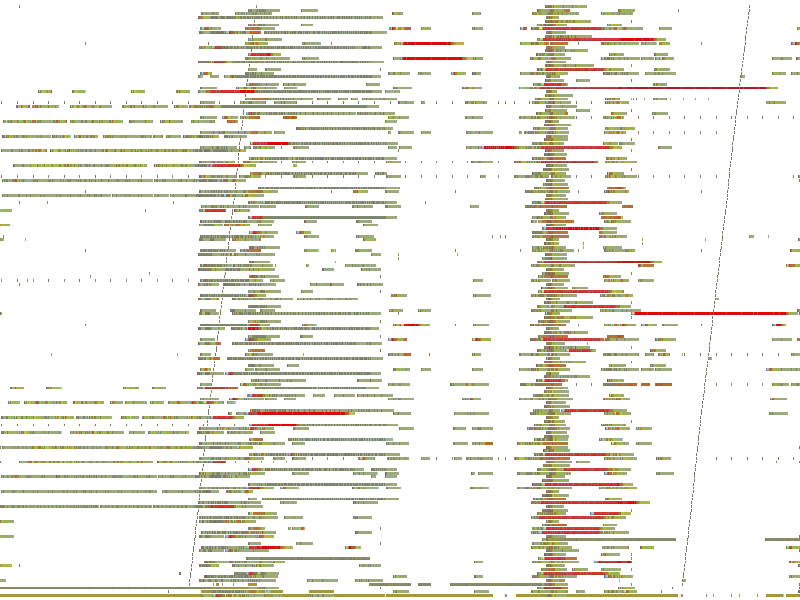

In [9]:
OPT['plot_width'] = 800
OPT['plot_height'] = 600
OPT['x_range'] = (0, max(result['x1']))
OPT['y_range'] = (-1, 161)
newfig()

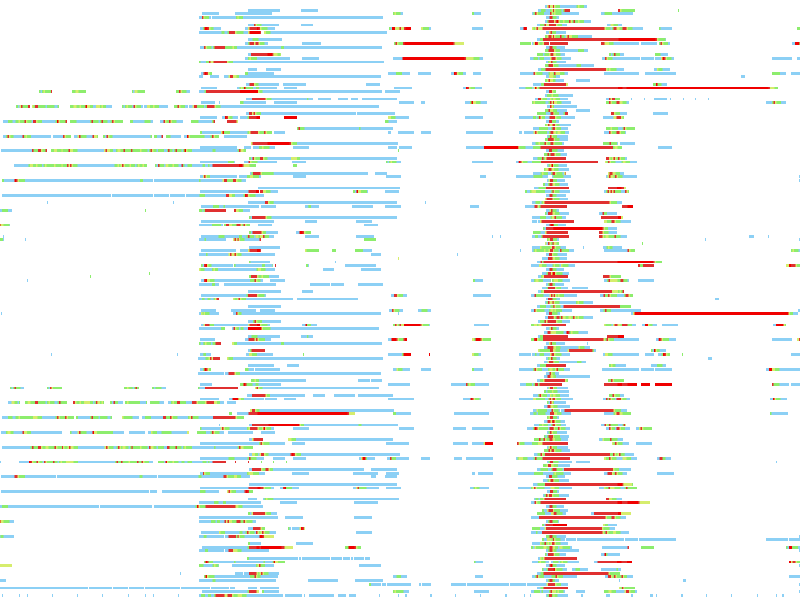

In [10]:
result = lines.query('c>=19')
newfig()

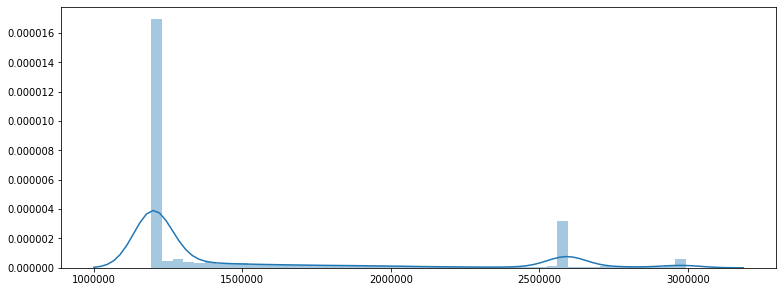

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6.4*2, 4.8))
frq = lines.query('c>=19')['arg1'].values
sns.distplot(frq);

In [14]:
BLOCK = lines.query('c==4')
pid, count = np.unique(BLOCK['pid'], return_counts=True)
MOST_BLOCK_PID = pid[np.argmax(count)]

In [16]:
CTX_SWITCH_OUT_OF_MOST_BLOCK_PID = lines.query(f'pid=={MOST_BLOCK_PID} & c==10')
CTX_SWITCH_IN_OF_MOST_BLOCK_PID = lines.query(f'arg0=={MOST_BLOCK_PID} & c==10')
print(len(CTX_SWITCH_OUT_OF_MOST_BLOCK_PID), len(CTX_SWITCH_IN_OF_MOST_BLOCK_PID))

857 857


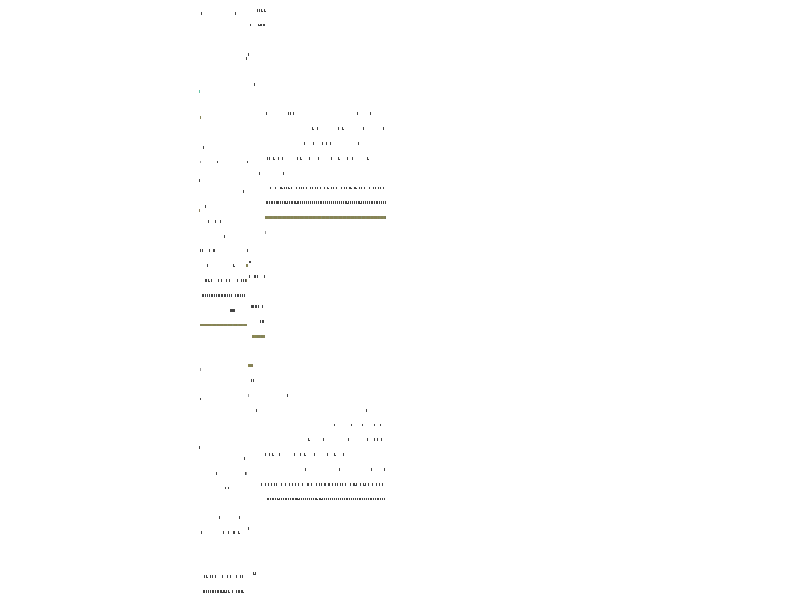

In [20]:
result = lines.query(f'pid=={MOST_BLOCK_PID}')
newfig(True)

In [27]:
FATHER = lines.query(f'pid=={MOST_BLOCK_PID} & c==9')['arg0'].values[0]

In [39]:
arg0, arg1 = lines.query(f'pid=={FATHER} & c==0')[['arg0','arg1']].values[0]

In [45]:
print(int(arg0).to_bytes(4, byteorder="little"), int(arg1).to_bytes(4, byteorder="little"))
## COMM value to EXEC is "sh"

b'\x00ma\x00' b'sh\x00e'
